<a href="https://colab.research.google.com/github/kulkarnisatishp/genai-course/blob/main/multimodel_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import userdata
openai_api_key = userdata.get('openai_key')

In [ ]:
%cd /content/drive/MyDrive/GenAI/RAG/Multimodal RAG

/content/drive/MyDrive/GenAI/RAG/Multimodal RAG


In [ ]:
video_path = "decision-making-course.mp4"

In [ ]:
!pip install -q pydub
!apt-get install -q ffmpeg

Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import os
import subprocess
from pydub import AudioSegment

In [ ]:
audio_output_path = "audios/output.mp3"

In [ ]:
command = [
    'ffmpeg', '-y', '-i', video_path, '-vn', '-acodec', 'libmp3lame', audio_output_path
]

In [ ]:
subprocess.run(command, check=True)

CompletedProcess(args=['ffmpeg', '-y', '-i', 'decision-making-course.mp4', '-vn', '-acodec', 'libmp3lame', 'audios/output.mp3'], returncode=0)

In [ ]:
bitrate = "32k"
compressed_audio_path = "audios/compressed_audio.mp3"

In [ ]:
command = [
    'ffmpeg', '-y', '-i', audio_output_path, '-ab', bitrate, compressed_audio_path
]
subprocess.run(command, check=True)

CompletedProcess(args=['ffmpeg', '-y', '-i', 'audios/output.mp3', '-ab', '32k', 'audios/compressed_audio.mp3'], returncode=0)

In [ ]:
!pip install -q openai

In [ ]:
from openai import OpenAI


In [ ]:
client = OpenAI(api_key=openai_api_key)

In [ ]:
with open(compressed_audio_path, "rb") as file:
    transcript = client.audio.transcriptions.create(
        model="whisper-1",
        file=file
    )

In [ ]:
transcription_path = "transcripts/transcript.txt"

In [ ]:
with open(transcription_path, "w") as file:
    file.write(transcript.text)


In [ ]:
!pip install -q moviepy

In [ ]:
from moviepy.editor import VideoFileClip

In [ ]:
output_folder = "frames"
video = VideoFileClip(video_path)

In [ ]:
frame_paths = []
interval = 10

for t in range(0, int(video.duration), interval):
  frame_path  = os.path.join(output_folder, f"frame_{t:04d}.png")
  video.save_frame(frame_path, t=t)
  frame_paths.append(frame_path)


In [ ]:
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import torch
import numpy as np

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
transcript_text = transcript.text

In [ ]:
tokens = tokenizer(transcript_text, return_tensors="pt", padding=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (9901 > 77). Running this sequence through the model will result in indexing errors


In [ ]:
tokens = tokens['input_ids'][0]
len(tokens)

9901

In [ ]:
max_tokens = 77
transctiption_chunks = []

for i in range(0, len(tokens), max_tokens):
  chunk = tokens[i:i+max_tokens]
  transctiption_chunks.append(chunk)

len(transctiption_chunks)

129

In [ ]:
text_embeddings =[]
for chunk in transctiption_chunks:
  inputs = {"input_ids": chunk.unsqueeze(0)}
  inputs
  with torch.no_grad():
    text_embedding = model.get_text_features(**inputs)
    text_embeddings.append(text_embedding.cpu().numpy().flatten())

text_embedding_np = np.array(text_embeddings)
text_embedding_np.shape

(129, 512)

In [ ]:
from PIL import Image

In [ ]:
frames_folder = "frames"
image_embeddings = []
image_paths = []

for frame_file in os.listdir(frames_folder):
  if frame_file.endswith(".png"):
    frame_path = os.path.join(frames_folder, frame_file)
    image_paths.append(frame_path)

    image = Image.open(frame_path)
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
      image_embedding = model.get_image_features(**inputs)
      image_embeddings.append(image_embedding.cpu().numpy().flatten())

image_embedding_np = np.array(image_embeddings)
image_embedding_np.shape

(373, 512)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import random

In [ ]:
similarities = cosine_similarity(text_embedding_np, image_embedding_np)
similarities.shape

(129, 373)

In [ ]:
top_k=5
for i, text_chunk in enumerate(similarities):
  similar_indices = text_chunk.argsort()[-top_k:][::-1]
  similar_images = [image_paths[idx] for idx in similar_indices]
  print (f"{i} : {similar_indices}")

0 : [ 94 300 258  21  34]
1 : [ 10 233 204 203 123]
2 : [205 326 359 114  96]
3 : [ 12  11 329 154  13]
4 : [ 80  12  62 237 120]
5 : [ 17 333 371 327 337]
6 : [224 200 226 349 337]
7 : [304 200  13   9  65]
8 : [357  69 352 356 351]
9 : [352 200 351  14 179]
10 : [ 72  71 241 239  46]
11 : [ 13 202 244 245   9]
12 : [ 79 356  78 351 346]
13 : [ 12  11  13 255 329]
14 : [337 259 203 204  14]
15 : [357 135 356 134  46]
16 : [265 264 301  73 185]
17 : [325 206 204 203  53]
18 : [ 31 206 124  14 205]
19 : [205  65  54 259  67]
20 : [  9  13 104  93 241]
21 : [105  11 332 346  46]
22 : [134 135 180 133 184]
23 : [303 304 305 302 301]
24 : [238 241 240 179  46]
25 : [200 244 345 124 186]
26 : [230 232 245 164 329]
27 : [  7 366 248  39 287]
28 : [108 109  12 149  13]
29 : [329 133  80  59  11]
30 : [218 288 289 103 217]
31 : [  9 250 124  39  95]
32 : [361 360 333 167  13]
33 : [344 329 162 345  64]
34 : [340 329 341  34 205]
35 : [259  65 164   9 332]
36 : [ 65 344 342 275 164]
37 : [153  

In [ ]:
random.seed(1502)
random_text_indices = random.sample(range(len(text_embedding_np)), 5)
random_image_indices = random.sample(range(len(image_embedding_np)), 5)

In [ ]:
text_to_images_similarities = []
for idx in random_text_indices:
  # Get indices of the top 3 most similar images for the text chunk
  similar_images = similarities[idx].argsort()[-3:][::-1]
  text_to_images_similarities.append(similar_images)


  The text chunk 1: powerful , and that it can inter fere with system 2 thinking , even when we consciously try to focus on something else . the st roo p effect can be extremely important when making presentations , as it highlights the influence of non - verbal cues and the way information is presented on our ability to process information accurately . for example , imagine you are making a presentation to a group of stakeholders , and


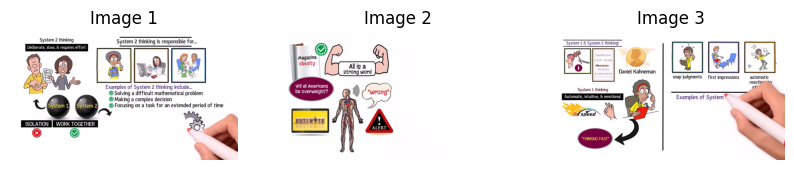


  The text chunk 2: though they would still be above average . the same thing happened to the bottom sec tile . the stores that were there in 1 9 1 6 were not the same as the ones in 1 9 2 2 . they would still be below average , but would no longer be the bottom performers . the same insight was similar in all industries . according to se christ , medi ocr ity tends to prevail


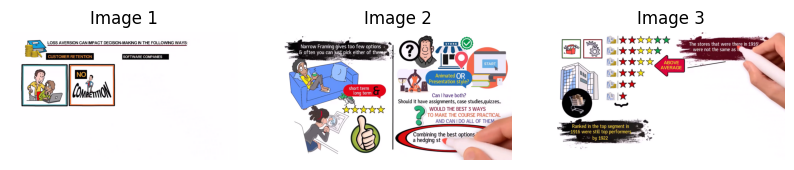


  The text chunk 3: euros , and you 're sure to make a choice that will make you more satisfied and happier . until the next video , have fun ! hey there , super excited to dive into the fascinating world of cognitive bi ases with you today . and , you know , it 's kind of funny how we humans think we 're like so smart and rational , but the truth is we 're all suscep tible


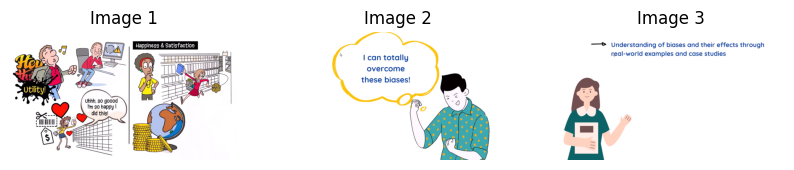


  The text chunk 4: . at the same time , companies observe this and conclude , well , being in silicon valley is doing wonders for them . maybe we should move there too . so , we would have more companies coming to silicon valley , potentially leading to more tech innovation . so , we have point a , which leads to point b , which once more leads to point a . this is called the mutual cau


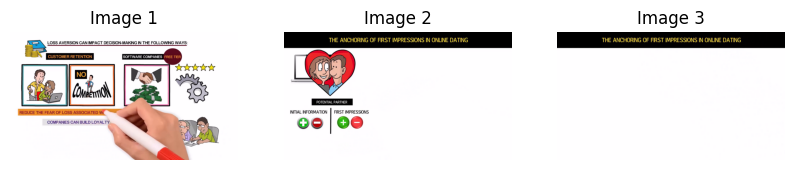


  The text chunk 5: pol ate until they found a year it would reach 1 0 0 %. now , you could say , okay , dio go , this is ridiculous . no one would extra pol ate like this . to which i reply , well , go check for yourself . go to google and search for , will all americans be overweight ? and it should be one of the first hits . it is quite obvious


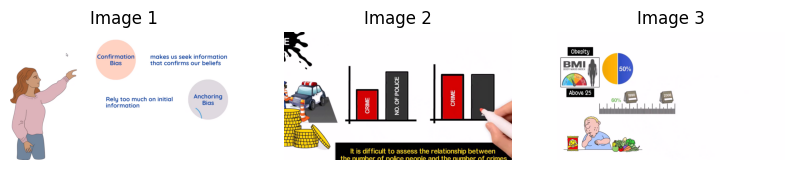

In [ ]:
for i, text_index in enumerate(random_text_indices):
  plt.figure(figsize = (10,8))

   # Displaying the text chunk
  print(f"""
  The text chunk {i + 1}: {' '.join([tokenizer.decode([token]) for token in transctiption_chunks[text_index]]
  )}""")

  # Displaying similar images corresponding to the current text chunk
  for j, image_idx in enumerate(text_to_images_similarities[i]):
    image = Image.open(image_paths[image_idx])
    plt.subplot(1, 3, j + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Image {j + 1}")

  plt.show() # Show the plot with images and text

In [ ]:
query = "Which cognitive biases are discussed?"

In [ ]:
query_tokens = tokenizer(query,
                         return_tensors = "pt",       # Return tensors in PyTorch format
                         padding = True)['input_ids'] # Pad tokens to ensure consistent length

In [ ]:
with torch.no_grad():
  query_embedding = model.get_text_features(
      input_ids = query_tokens  # Pass tokenized query to model
  ).cpu().numpy().flatten()     # Convert to numpy array and flatten to 1D

# Print shape of the embedding
print(f"The shape of the query embedding is {query_embedding.shape}")

The shape of the query embedding is (512,)


In [ ]:
text_similarities = cosine_similarity([query_embedding], text_embedding_np)[0]
text_similarities

array([0.7514168 , 0.37553275, 0.46643105, 0.28114367, 0.5543841 ,
       0.5052882 , 0.3549536 , 0.4351248 , 0.5209272 , 0.45069286,
       0.39892346, 0.3761024 , 0.45080036, 0.31673908, 0.43138254,
       0.54334515, 0.49713024, 0.32667792, 0.33640847, 0.3016773 ,
       0.30833155, 0.39499748, 0.33290058, 0.30464497, 0.22395614,
       0.581675  , 0.39684236, 0.60200566, 0.4523488 , 0.5061942 ,
       0.4029535 , 0.33782965, 0.31618637, 0.29989526, 0.45112413,
       0.44300923, 0.3652453 , 0.63439673, 0.38532725, 0.52638733,
       0.21184626, 0.30226848, 0.49422   , 0.46977967, 0.46552637,
       0.5181213 , 0.76586807, 0.4252528 , 0.2899684 , 0.3834664 ,
       0.55535376, 0.3591588 , 0.5178304 , 0.5104439 , 0.4122749 ,
       0.47198784, 0.34506467, 0.34283358, 0.49865273, 0.36217588,
       0.21252176, 0.33943987, 0.4284376 , 0.46468177, 0.40190884,
       0.5878546 , 0.34711984, 0.44224685, 0.4219517 , 0.4791632 ,
       0.34402218, 0.34355405, 0.39909947, 0.14296117, 0.47422

In [ ]:
top_k_texts = 10
top_k_text_indices = text_similarities.argsort()[-top_k_texts:][::-1]
top_k_text_indices

array([128,  46, 100, 103,   0,  37,  92,  27,  65,  25])

In [ ]:
# Retrieve the closest images for each text chunk
top_k_images_indices = []
images_per_chunk = 2 # Number of top similar images to retrieve for each text chunk

for idx in top_k_text_indices:
  # Find indices of the top-k similar images for the current text chunk
  similar_images = similarities[idx].argsort()[-images_per_chunk:][::-1]
  top_k_images_indices.append(similar_images)  # Add to the list

# Remove any duplicates and limit to the top k images
top_k_images_indices = list(set([item for sublist in top_k_images_indices for item in sublist]))

# Print the number of unique image indices
print(f"The total images indices are {len(top_k_images_indices)}")

The total images indices are 14


In [ ]:
import base64

In [ ]:
# Combining the retrieved text chunks
retrieved_text = []

for idx in top_k_text_indices:
  # Decode and append each text chunk using the tokenizer
  retrieved_text.append(tokenizer.decode(transcription_chunks[idx]))

# Join all the text chunks into a single string
retrieved_text = ' '.join(retrieved_text)
retrieved_text

In [ ]:
# Convert the images and append them
base64frames = []

for idx in top_k_images_indices:
  image_path = image_paths[idx]  # Get the path of the image

  # Open the image file in binary read mode
  with open(image_path, "rb") as image_file:
    # Encode the image file content to base64 and decode to UTF-8 string
    base64_image = base64.b64encode(image_file.read()).decode('utf-8')
    base64frames.append(base64_image) # Append the encoded image string to the list

base64frames

In [ ]:
MODEL = "gpt-4o-mini"

# Define the system prompt
system_prompt = """
You are an expert teacher that summarises visual and transcribed content
"""

In [ ]:
user_message_content = [
    "These are the frames from the video",                                # Initial message indicating the following content
    *map(lambda x: {"type": "image_url",                                  # Map each base64-encoded image to the appropriate format
                    "image_url": {"url": f'data:image/jpg;base64,{x}',
                                 "detail": "high"}},
         base64frames),
    {"type": "text",                                                      # Append the retrieved text as a separate message
     "text": retrieved_text}
]

In [ ]:
response = client.chat.completions.create(
    model = MODEL, # Specify the model to use for the completion
    messages = [
        {"role": "system", "content": system_prompt}, # Provide system prompt to guide the model
        {"role": "user", "content": user_message_content}, # Provide user message content with images and text
    ],
    temperature = 0.3,  # Set the temperature to control the randomness of the output
)

In [ ]:
generated_response = response.choices[0].message.content
print(generated_response)